In [1]:
import collections
import csv
import keras
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import time
import shap
import ROOT as root
from sklearn.preprocessing import StandardScaler

from keras import optimizers
from keras.regularizers import l2

from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add
from keras import activations

from ROOT import TFile, TLorentzVector

from tools.constants import *

Welcome to JupyROOT 6.22/08


In [2]:
""" Data augmentation. """
def random_rotation(X,deltas_phi,num_vectors,met, met_indices = [-11,-10]):

    for i in range(num_vectors):
        
        R = np.sqrt((X[:,4*i+0]**2 + X[:,4*i+1]**2))
        old_phis = np.arctan2(X[:,4*i+1],X[:,4*i+0])
        new_phis = old_phis + deltas_phi

        angles_sin = np.sin(new_phis)
        angles_cos = np.cos(new_phis)

        X[:,4*i+0] = angles_cos * R
        X[:,4*i+1] = angles_sin * R
        
    if met:
        return random_rotation_MET(X, deltas_phi, met_indices)
    else:
        return X


def random_rotation_MET(X, deltas_phi, met_indices = [-11,-10]):

    R = np.sqrt((X[:,met_indices[0]]**2 + X[:,met_indices[1]]**2))
    old_phis = np.arctan2(X[:,met_indices[1]],(X[:,met_indices[0]]))
    new_phis = old_phis + deltas_phi

    angles_sin = np.sin(new_phis)
    angles_cos = np.cos(new_phis)

    X[:,met_indices[0]] = angles_cos * R
    X[:,met_indices[1]] = angles_sin * R

    return X


def data_rotation(X, y, num_vectors_X = 11, num_vectors_y = 5, met = True):   # VECTORS HAVE TO BE FIRST AND MET -7,-6 AND ANYTHING ELSE INBETWEEN !!!!!!!!!!!
    
    deltas_phi = np.random.rand(X.shape[0])*2*math.pi
    X = random_rotation(X,deltas_phi,num_vectors_X,met,[-11,-10])
    y = random_rotation(y,deltas_phi,num_vectors_y,met,[-2,-1])
        
    return X,y

""" Data generator for serving the NN data. """
# modified from source: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, scaler = ["scaler_params/X_scaler_mass_reco_narrow_btags.csv"], batch_size=32, n_features=76, shuffle=True, augmentation = True, ceil = False):
        self.n_features = n_features
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.ceil = ceil
        self.indexes = np.arange(len(X))
        with open(scaler[0]) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.X_scaler = scaler_params[0:2,:]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.ceil:
            return int(np.ceil(len(self.X) / self.batch_size))
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y, weights = self.__data_generation(indexes)
        return X, y, weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)

        X = self.X[indexes]

        weights = X[:,-1]
        X = X[:,:-1]

        y = self.y[indexes]

        if self.augmentation:
            X,y = data_rotation(X,y, num_vectors_X = 11, num_vectors_y = 5, met = True)
        X = (X-self.X_scaler[0])/self.X_scaler[1]     # Standardize            #54-60 64 66 67-71
        # We do not scale the y, since we want to use mass and momentum conservation equations.

        return X, y, weights
    
    def get_all(self):
        'Get all data - all batches.'
        X = []
        y = []

        for i in range(self.__len__()):
            X_y = self.__getitem__(i)
            X += X_y[0].tolist()
            y += X_y[1].tolist()

        X = np.array(X)
        y = np.array(y)
        
        return X, y

In [3]:
# Load data.

def add_weights(tth,ttz):
    """ Class weights, because of the imbalance between the productions' number of events. """
    weight_tth = 1/(2*len(tth)/(len(ttz)+len(tth)))
    weight_ttz = 1/(2*len(ttz)/(len(ttz)+len(tth)))

    print(weight_tth)
    print(weight_ttz)

    ones = np.ones((tth.shape[0],1))
    tth = np.concatenate((tth, weight_tth*ones),axis=1)

    ones = np.ones((ttz.shape[0],1))
    ttz = np.concatenate((ttz, weight_ttz*ones),axis=1)

    return tth,ttz

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_train_ttH.csv") as f: 
    X_y_train_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_train_ttZ.csv") as f: 
    X_y_train_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_test_ttH.csv") as f: 
    X_y_test_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_test_ttZ.csv") as f: 
    X_y_test_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_val_ttH.csv") as f: 
    X_y_val_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_val_ttZ.csv") as f: 
    X_y_val_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)


X_y_train_ttH, X_y_train_ttZ = add_weights(X_y_train_ttH, X_y_train_ttZ)    # Add weights to the data
X_y_train = np.concatenate((X_y_train_ttH, X_y_train_ttZ), axis=0)          # Combine ttH and ttZ for training.
X_train = np.concatenate((X_y_train[:,:-10], X_y_train[:,-6:]), axis = 1)   # Seprate X and y
# For the y we select specific variable that we will use in the loss function.
y_train = X_y_train[:,[-10,-9,-8,-7,28,29,30,31,12,13,14,15,4,5,6,7,16,17,18,19,-16,-15]]/1000

X_y_val_ttH, X_y_val_ttZ = add_weights(X_y_val_ttH, X_y_val_ttZ)
X_y_val = np.concatenate((X_y_val_ttH, X_y_val_ttZ), axis=0)
X_val = np.concatenate((X_y_val[:,:-10], X_y_val[:,-6:]), axis = 1)   
y_val = X_y_val[:,[-10,-9,-8,-7,28,29,30,31,12,13,14,15,4,5,6,7,16,17,18,19,-16,-15]]/1000

X_y_test_ttH, X_y_test_ttZ = add_weights(X_y_test_ttH, X_y_test_ttZ)
X_y_test = np.concatenate((X_y_test_ttH, X_y_test_ttZ), axis=0)
X_test = np.concatenate((X_y_test[:,:-10], X_y_test[:,-6:]), axis = 1)   
y_test = X_y_test[:,[-10,-9,-8,-7,28,29,30,31,12,13,14,15,4,5,6,7,16,17,18,19,-16,-15]]/1000

num_features = X_train.shape[1]-1   # exclude weights
num_samples = X_train.shape[0]

print(num_features,num_samples)

0.8002137488795421
1.3327400091869543
0.8011647254575707
1.330110497237569
0.8
1.3333333333333333
76 23211


In [4]:
train_generator = DataGenerator(X_train, y_train, n_features = num_features, batch_size=4096, shuffle=True, augmentation = True, ceil = False)
val_generator = DataGenerator(X_val, y_val, n_features = num_features, batch_size=128, shuffle=False, augmentation = False, ceil = True)
test_generator = DataGenerator(X_test, y_test, n_features = num_features, batch_size=128, shuffle=False, augmentation = False, ceil = True)

In [5]:
import sys
EPSILON = 0.0000001

""" Loss function helpers. """

def calculate_mass(four_vecs):
    E2 = tf.math.square(four_vecs[:,3])
    p2 = tf.math.reduce_sum(tf.square(four_vecs[:,:3]), axis = 1)
    mask = tf.math.less(p2, E2)
    mask = tf.cast(mask, tf.float32)*2-1
    Mag2 = tf.math.multiply(mask,(E2-p2))
    Mag = tf.sqrt(tf.math.maximum(Mag2, EPSILON))
    Mag = tf.math.multiply(mask,Mag)
    return Mag

def calculate_transverse_energy(four_vecs):
    E = tf.expand_dims(four_vecs[:,3],1)
    E = tf.tile(E,tf.constant([1,2]))
    pT = four_vecs[:,0:2]
    p_norm = tf.expand_dims(tf.norm(four_vecs[:,0:3],axis=1),1)
    p_norm = tf.tile(p_norm,tf.constant([1,2]))
    ET = tf.math.divide_no_nan(tf.math.multiply(pT,E),p_norm)
    return ET

""" Loss function. """

def custom_loss(y_true, y_pred):
    """ Coeficients set as to achieve a balanced loss. However, changing them did not
        affect the results much. """
    NU_LOSS_COEF = tf.constant(0.15, tf.float32)
    W_LOSS_COEF = tf.constant(0.22, tf.float32)
    TAU_LOSS_COEF = tf.constant(1.0, tf.float32)
    TOP_LOSS_COEF = tf.constant(0.05, tf.float32)
    HIGGS_LOSS_COEF = tf.constant(0.075, tf.float32)
    MET_LOSS_COEF = tf.constant(0.015, tf.float32)
    HIGGS_MSE_COEF = tf.constant(0.011, tf.float32)

    """ Necessary variables. """
    W_MASS = tf.constant(80.39)
    TAU_MASS = tf.constant(1.777)
    TOP_MASS = tf.constant(173.1)
    NU_MASS = tf.constant(0.0)
    true_higgs = y_true[:,0:4]
    hadr_tau_hadr = y_true[:,4:8]
    lep_tau_l = y_true[:,8:12]
    anti_top_b = y_true[:,12:16]
    anti_top_lep = y_true[:,16:20]
    met_x = y_true[:,20]
    met_y = y_true[:,21]
    neutrino_1 = y_pred[:,0:4]
    neutrino_2 = y_pred[:,4:8]
    neutrino_3 = y_pred[:,8:12]
    neutrino_4 = y_pred[:,12:16]

    """ Predicted MET """
    invis = neutrino_1 + neutrino_2 + neutrino_3 + neutrino_4
    invis_ET = calculate_transverse_energy(invis)

    """ Predicted combined particles. """
    hadr_tau = tf.math.add(hadr_tau_hadr, neutrino_1)
    lep_tau_W = tf.math.add(lep_tau_l, neutrino_3)
    lep_tau = tf.math.add(lep_tau_W, neutrino_2)
    anti_top_W = tf.math.add(anti_top_lep, neutrino_4)
    anti_top = tf.math.add(anti_top_W, anti_top_b)
    higgs = tf.math.add(hadr_tau, lep_tau)

    """ Conservation formulas (squared difference). """
    neutrino_1_mass_loss =  NU_LOSS_COEF * tf.math.square(calculate_mass(neutrino_1))
    neutrino_2_mass_loss =  NU_LOSS_COEF * tf.math.square(calculate_mass(neutrino_2))
    neutrino_3_mass_loss =  NU_LOSS_COEF * tf.math.square(calculate_mass(neutrino_3))
    neutrino_4_mass_loss =  NU_LOSS_COEF * tf.math.square(calculate_mass(neutrino_4))
    lep_tau_W_mass_loss =   W_LOSS_COEF * tf.math.square(calculate_mass(lep_tau_W)-W_MASS)
    anti_top_W_mass_loss =  W_LOSS_COEF * tf.math.square(calculate_mass(anti_top_W)-W_MASS)
    lep_tau_mass_loss =     TAU_LOSS_COEF * tf.math.square(calculate_mass(lep_tau)-TAU_MASS)
    hadr_tau_mass_loss =    TAU_LOSS_COEF * tf.math.square(calculate_mass(hadr_tau)-TAU_MASS)
    anti_top_mass_loss =    TOP_LOSS_COEF * tf.math.square(calculate_mass(anti_top)-TOP_MASS)
    higgs_mass_loss =       HIGGS_LOSS_COEF * tf.math.square(calculate_mass(higgs)-calculate_mass(true_higgs))
    met_x_loss =            MET_LOSS_COEF * tf.math.square(met_x-invis_ET[:,0])
    met_y_loss =            MET_LOSS_COEF * tf.math.square(met_y-invis_ET[:,1])

    """ Sum up the individual formulas. """
    ret = tf.add_n([neutrino_1_mass_loss, neutrino_2_mass_loss, neutrino_3_mass_loss, neutrino_4_mass_loss, \
                    lep_tau_W_mass_loss, anti_top_W_mass_loss, lep_tau_mass_loss, hadr_tau_mass_loss, \
                    anti_top_mass_loss, higgs_mass_loss, met_x_loss, met_y_loss])
    return ret

""" Define NN architecture. """

def baseline_model(num_features):

    i = keras.Input(shape = (num_features,))
    dropout_1 = Dropout(0.2)(i)
    dense_1 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_1)
    relu_1 = Activation(activations.relu)(dense_1)

    dropout_2 = Dropout(0.2)(relu_1)
    dense_2 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_2)
    relu_2 = Activation(activations.relu)(dense_2)

    dropout_3 = Dropout(0.2)(relu_2)
    dense_3 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_3)
    relu_3 = Activation(activations.relu)(dense_3)

    dropout_4 = Dropout(0.2)(relu_3)
    dense_4 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_4)
    relu_4 = Activation(activations.relu)(dense_4)

    dropout_5 = Dropout(0.2)(relu_4)
    dense_5 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_5)
    relu_5 = Activation(activations.relu)(dense_5)

    dropout_6 = Dropout(0.2)(relu_5)
    dense_6 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_6)
    relu_6 = Activation(activations.relu)(dense_6)

    dropout_7 = Dropout(0.2)(relu_6)
    o = Dense(16, activation='linear', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_7)

    model = keras.Model(i, o)
    model.compile(loss=custom_loss, optimizer=optimizers.Adam(lr=0.0005, beta_1=0.9))
    model.summary()
    return model

def scheduler(epoch, lr):
    return lr * 0.99

In [6]:
""" Training. Callbacks used are learning rate decay and early stopping. """
model = baseline_model(num_features)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(x=train_generator, validation_data = val_generator, epochs=300, verbose=1, callbacks = [callback1, callback2])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 76)                0         
_________________________________________________________________
dense (Dense)                (None, 760)               58520     
_________________________________________________________________
activation (Activation)      (None, 760)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 760)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 760)               578360    
_________________________________________________________________
activation_1 (Activation)    (None, 760)               0     

2022-01-04 10:03:04.936495: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-04 10:03:04.937125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 10:03:04.940158: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-01-04 10:03:05.125257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-04 10:03:05.125975: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3100000000 Hz


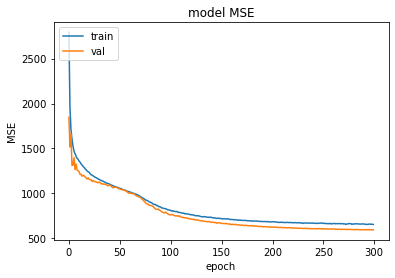

<Figure size 432x288 with 0 Axes>

In [7]:
""" Training history plot. """

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim(0.6,1)
plt.show()
plt.clf()

In [8]:
""" Save model. """
model.save("models/mass_reco_narrow_mmc_inspired_btags")

INFO:tensorflow:Assets written to: models/mass_reco_narrow_mmc_inspired_btags/assets


2022-01-04 10:23:31.827684: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


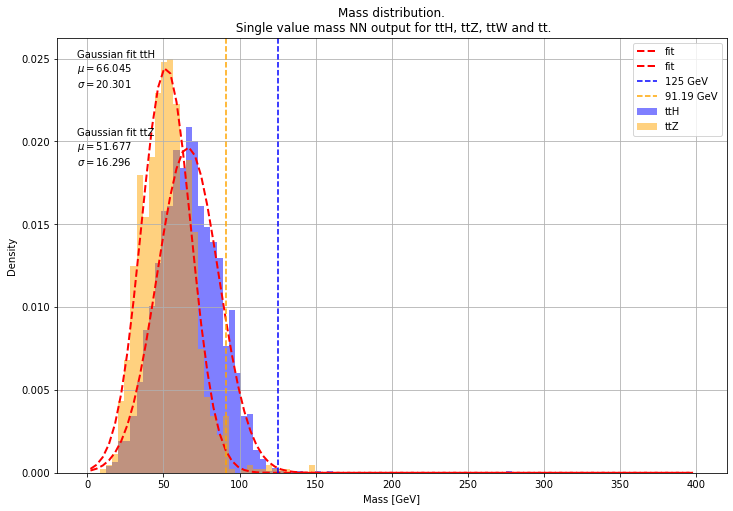

66.93870080566218 20.40711187478544


In [12]:
""" Pyplot histogram. """

from scipy.optimize import curve_fit
from scipy.stats import crystalball, norm

ttH_eval_generator = DataGenerator(np.concatenate((X_y_test_ttH[:,:-10], X_y_test_ttH[:,-6:]), axis = 1), X_y_test_ttH[:,[-10,-9,-8,-7,28,29,30,31,12,13,14,15,4,5,6,7,16,17,18,19,-16,-15]]/1000, n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)
ttZ_eval_generator = DataGenerator(np.concatenate((X_y_test_ttZ[:,:-10], X_y_test_ttZ[:,-6:]), axis = 1), X_y_test_ttZ[:,[-10,-9,-8,-7,28,29,30,31,12,13,14,15,4,5,6,7,16,17,18,19,-16,-15]]/1000, n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)

ttH_y_pred = model.predict(ttH_eval_generator)
X_y = ttH_eval_generator.get_all()
ttH_X_eval = X_y[0]
ttH_y_true = X_y[1]

ttZ_y_pred = model.predict(ttZ_eval_generator)
X_y = ttZ_eval_generator.get_all()
ttZ_X_eval = X_y[0]
ttZ_y_true = X_y[1]

with open("scaler_params/X_scaler_mass_reco_narrow_btags.csv") as f:
    scaler_params = np.loadtxt(f, delimiter=",")
    X_scaler = scaler_params[0:2,:]

ttH_X_eval = ttH_X_eval * X_scaler[1] + X_scaler[0]
ttZ_X_eval = ttZ_X_eval * X_scaler[1] + X_scaler[0]

predicted_higgs_masses = []
predicted_Z_masses = []

VIS_TAU_HADR_INDEX = 12
VIS_TAU_LEP_INDEX = 28


for i in range(len(ttH_X_eval)):

    X_eval_sample = ttH_X_eval[i]
    y_pred_sample = ttH_y_pred[i]
    y_true_sample = ttH_y_true[i]

    hadr_tau_visible = TLorentzVector(X_eval_sample[VIS_TAU_HADR_INDEX],X_eval_sample[VIS_TAU_HADR_INDEX+1],X_eval_sample[VIS_TAU_HADR_INDEX+2],X_eval_sample[VIS_TAU_HADR_INDEX+3])
    lep_tau_visible = TLorentzVector( X_eval_sample[VIS_TAU_LEP_INDEX], X_eval_sample[VIS_TAU_LEP_INDEX+1], X_eval_sample[VIS_TAU_LEP_INDEX+2], X_eval_sample[VIS_TAU_LEP_INDEX+3])
    predicted_hadr_tau_n = TLorentzVector( y_pred_sample[0],y_pred_sample[1],y_pred_sample[2], y_pred_sample[3])
    predicted_lep_tau_n = TLorentzVector(  y_pred_sample[4],y_pred_sample[5],y_pred_sample[6], y_pred_sample[7])
    predicted_lep_tau_W_n = TLorentzVector(y_pred_sample[8],y_pred_sample[9],y_pred_sample[10],y_pred_sample[11])
    
    predicted_hadr_tau = hadr_tau_visible + predicted_hadr_tau_n
    predicted_lep_tau = lep_tau_visible + predicted_lep_tau_n + predicted_lep_tau_W_n

    predicted_higgs = predicted_hadr_tau + predicted_lep_tau

    predicted_higgs_masses.append(predicted_higgs.Mag()/1000)

for i in range(len(ttZ_X_eval)):

    X_eval_sample = ttZ_X_eval[i]
    y_pred_sample = ttZ_y_pred[i]
    y_true_sample = ttZ_y_true[i]

    hadr_tau_visible = TLorentzVector(X_eval_sample[VIS_TAU_HADR_INDEX],X_eval_sample[VIS_TAU_HADR_INDEX+1],X_eval_sample[VIS_TAU_HADR_INDEX+2],X_eval_sample[VIS_TAU_HADR_INDEX+3])
    lep_tau_visible = TLorentzVector( X_eval_sample[VIS_TAU_LEP_INDEX], X_eval_sample[VIS_TAU_LEP_INDEX+1], X_eval_sample[VIS_TAU_LEP_INDEX+2], X_eval_sample[VIS_TAU_LEP_INDEX+3])
    predicted_hadr_tau_n = TLorentzVector( y_pred_sample[0],y_pred_sample[1],y_pred_sample[2], y_pred_sample[3])
    predicted_lep_tau_n = TLorentzVector(  y_pred_sample[4],y_pred_sample[5],y_pred_sample[6], y_pred_sample[7])
    predicted_lep_tau_W_n = TLorentzVector(y_pred_sample[8],y_pred_sample[9],y_pred_sample[10],y_pred_sample[11])
    
    predicted_hadr_tau = hadr_tau_visible + predicted_hadr_tau_n
    predicted_lep_tau = lep_tau_visible + predicted_lep_tau_n + predicted_lep_tau_W_n

    predicted_Z = predicted_hadr_tau + predicted_lep_tau

    predicted_Z_masses.append(predicted_Z.Mag()/1000)



plt.figure(figsize=(12,8))

n, bins, patches = plt.hist(predicted_higgs_masses, bins=np.linspace(0,400,100), alpha = 0.5, density = True, color='blue')
centers = (0.5*(bins[1:]+bins[:-1]))
mean,std = norm.fit(predicted_higgs_masses)
p0 = [mean, std]
pars1, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=p0)
plt.plot(centers, norm.pdf(centers,*pars1), 'r--',linewidth = 2, label='fit before') 
plt.annotate("Gaussian fit ttH" "\n" r'$\mu=%.3f$' "\n" r'$\sigma=%.3f$' % (pars1[0], pars1[1]), xy=(0, 1), xytext=(20, -12), va='top',
	             xycoords='axes fraction', textcoords='offset points')

n, bins, patches = plt.hist(predicted_Z_masses, bins=np.linspace(0,400,100), alpha = 0.5, density = True, color='orange')
centers = (0.5*(bins[1:]+bins[:-1]))
mean,std = norm.fit(predicted_Z_masses)
p0 = [mean, std]
pars2, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=p0)
plt.plot(centers, norm.pdf(centers,*pars2), 'r--',linewidth = 2, label='fit before') 
plt.annotate("Gaussian fit ttZ" "\n" r'$\mu=%.3f$' "\n" r'$\sigma=%.3f$' % (pars2[0], pars2[1]), xy=(0, 1), xytext=(20, -90), va='top',
	             xycoords='axes fraction', textcoords='offset points')

plt.axvline(125,color='blue', linestyle='dashed')
plt.axvline(91.19,color='orange', linestyle='dashed')
plt.title("Mass distribution.\n Single value mass NN output for ttH, ttZ, ttW and tt.")
plt.xlabel("Mass [GeV]")
plt.ylabel("Density")
plt.legend(["fit","fit","125 GeV","91.19 GeV","ttH","ttZ"])
plt.grid()
plt.savefig("figures/mass_histo_narrow_pyplot_mmc_inspired_btags.pdf")
plt.show()
print(np.mean(predicted_higgs_masses),np.std(predicted_higgs_masses))

0.8
1.3333333333333333


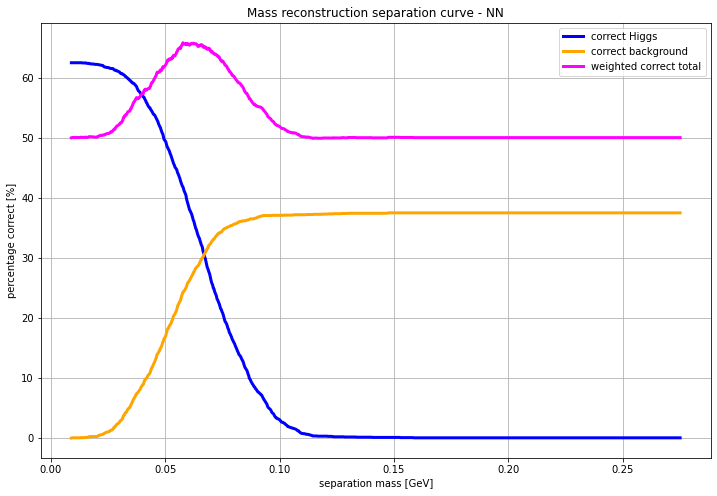

65.84022038567494


In [10]:
""" Separation curve. """

min_mass = np.min(np.concatenate((predicted_higgs_masses, predicted_Z_masses)))
max_mass = np.max(np.concatenate((predicted_higgs_masses, predicted_Z_masses)))

bg_weight = (len(predicted_Z_masses)+len(predicted_higgs_masses))/2/len(predicted_Z_masses)
h_weight = (len(predicted_Z_masses)+len(predicted_higgs_masses))/2/len(predicted_higgs_masses)
print(h_weight)
print(bg_weight)

n_steps = 1000
step_size = (max_mass-min_mass)/n_steps
current_divider = min_mass

correct_h = np.zeros((n_steps))
correct_bg = np.zeros((n_steps))

incorrect_h = np.zeros((n_steps))
incorrect_bg = np.zeros((n_steps))

steps = np.zeros((n_steps))

for i in range(n_steps):

    current_divider = min_mass+i*step_size
    steps[i] = current_divider

    for h_mass in predicted_higgs_masses:
        if h_mass < current_divider:
            incorrect_h[i] += 1
        else:
            correct_h[i] += 1

    for z_mass in predicted_Z_masses:
        if z_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1

steps = steps/1000
correct_h /= (len(predicted_higgs_masses)+len(predicted_Z_masses))/100
correct_bg /= (len(predicted_higgs_masses)+len(predicted_Z_masses))/100
plt.figure(figsize=(12,8))
plt.plot(steps, correct_h, linewidth=3, color='blue')
plt.plot(steps, correct_bg, linewidth=3, color='orange')
plt.plot(steps, h_weight*correct_h + bg_weight*correct_bg, linewidth=3, color='magenta')
plt.title("Mass reconstruction separation curve - NN")
plt.xlabel("separation mass [GeV]")
plt.ylabel("percentage correct [%]")
plt.legend(["correct Higgs","correct background","weighted correct total"])
plt.grid()
plt.savefig("figures/mass_histo_narrow_separation_mmc_inspired_btags.pdf")
plt.show()
print(np.max(h_weight*correct_h + bg_weight*correct_bg))

In [11]:
""" ROOT histogram. """
import atlasplots as aplt
import root_numpy
from ROOT import TF1, TLine

aplt.set_atlas_style()

H_line = TLine(125.18,0,125.18,1000)
H_line.SetLineStyle(9)
H_line.SetLineWidth(3)
Z_line = TLine(91.19,0,91.19,1000)
Z_line.SetLineStyle(9)
Z_line.SetLineWidth(3)

gauss_fit_1 = TF1("gauss_fit_1","gaus(0)",0,150)
gauss_fit_1.SetParameters(1, 1, 1)

gauss_fit_2 = TF1("gauss_fit_2","gaus(0)",0,150)
gauss_fit_2.SetParameters(1, 1, 1)

ttH = root.TH1F("ttH","",20,0,150)
root_numpy.fill_hist(ttH, predicted_higgs_masses)

weights = np.ones(len(predicted_Z_masses))*(len(predicted_higgs_masses)/len(predicted_Z_masses))

ttZ = root.TH1F("ttZ","",20,0,150)
root_numpy.fill_hist(ttZ, predicted_Z_masses, weights)

fig, ax = aplt.subplots(1, 1)

ttH.Fit("gauss_fit_2","0")
gauss_fit_2.SetNpx(1000)
ax.plot(gauss_fit_2, label="Fit", labelfmt="L", linecolor=root.kRed+1, linewidth=3)

ttZ.Fit("gauss_fit_1","0")
gauss_fit_1.SetNpx(1000)
ax.plot(gauss_fit_1, label=None, labelfmt="L", linecolor=root.kRed+1, linewidth=3)

ttH_fit = ttH.GetFunction("gauss_fit_2")
print(ttH_fit.GetParameter(0))
print(ttH_fit.GetParameter(1))
print(ttH_fit.GetParameter(2))
ax.plot(H_line, linecolor='black', label=None, labelfmt="L")
ax.plot(Z_line, linecolor='black', label=None, labelfmt="L")
ax.plot(ttH, linecolor='blue', linewidth=3, label="ttH", labelfmt="L")
ax.plot(ttZ, linecolor=807, linewidth=3, label="ttZ", labelfmt="L")
ax.set_xlim(0, 150)
ax.set_ylim(0, 400)
ax.set_xlabel("Mass [GeV]")
ax.set_ylabel("Events")
ax.add_margins(top=0.15)
ax.legend(loc=(0.84, 0.7, 0.95, 0.92))
fig.savefig("figures/mass_histo_narrow_root_mmc_inspired_btags.pdf")

Applying ATLAS style settings


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


277.5929016497339
66.99777314007414
19.280921169472535
 FCN=24.9576 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=2.23795e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.77593e+02   7.75175e+00   1.63368e-02  -2.03859e-05
   2  Mean         6.69978e+01   4.67824e-01   1.14099e-03  -2.51763e-04
   3  Sigma        1.92809e+01   2.88896e-01   1.02557e-05  -3.59356e-02
 FCN=38.3569 FROM MIGRAD    STATUS=CONVERGED      70 CALLS          71 TOTAL
                     EDM=4.67907e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.44221e+02   1.27434e+01   3.25294e-02  -1.49849e-08
   2  Mean         5.24325e+01   4.85431e-01   1.45

Info in <TCanvas::Print>: pdf file figures/mass_histo_narrow_root_mmc_inspired_btags.pdf has been created
